In [1]:
import sys
sys.path.append("core")
from chips import RegisterAIA
import datetime as dt
import numpy as np
import cv2
from scipy import signal

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [2]:
_dict_ = {}
_dict_["date"] = dt.datetime(2018,5,30,12)
_dict_["wavelength"] = 193
_dict_["resolution"] = 1024
_dict_["vmin"] = 35
aia = RegisterAIA(_dict_["date"], _dict_["wavelength"], _dict_["resolution"], vmin=_dict_["vmin"])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

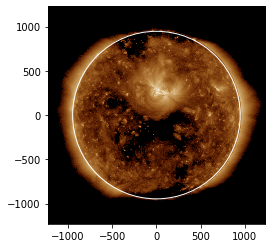

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.hist(aia.m_normalized.data.ravel(), bins=100, histtype="step", density=True)
#ax.set_xscale("log")
aia.m_normalized.plot(annotate=False, axes=ax, vmin=_dict_["vmin"])
aia.m_normalized.draw_limb()
plt.show()

array([ 13.04061684,  18.36412574,  19.54712771,  26.05363859,
        40.24966232,  42.02416528,  46.1646722 ,  52.67118308,
        55.62868802,  57.99469198,  59.76919494,  62.72669989,
        64.50120285,  66.27570582,  92.30174932,  99.39976118,
       102.35726613, 104.13176909, 107.08927404, 108.27227601,
       109.45527799, 111.82128195, 113.59578491, 118.32779282,
       119.5107948 , 120.69379678, 123.65130172, 126.01730568,
       127.20030765, 132.52381655, 134.29831952, 135.48132149,
       137.25582446, 138.43882644, 139.62182841])

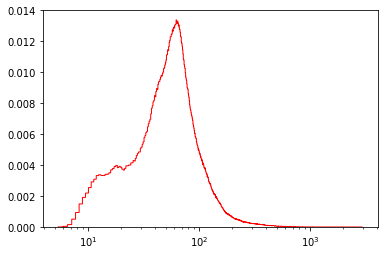

In [4]:
rsun_obs = 1.7*aia.m_normalized.rsun_obs.value
mask = np.zeros_like(aia.m_normalized.data)*np.nan
cv2.circle(mask, (2048,2048), int(rsun_obs), 255, -1)
mask[mask==255] = 1
fig = plt.figure()
ax = fig.add_subplot(111)
data = mask * signal.medfilt2d(aia.m_normalized.data, 3)
h, be, _ = ax.hist(data.ravel(), bins=5000, histtype="step", color="r", density=True)
ax.set_xscale("log")
bc = be[:-1] + np.diff(be)
peaks, _ = signal.find_peaks(h, height=.002)
peak_points = bc[peaks]
peak_points

In [5]:
lims = np.arange(0,33) # Change this parameter (-15, 15)
tmp_map = {}
prob_map = {}
for lim in lims:
    peak = peak_points[0] + lim
    tmp = np.copy(data)
    mask = np.zeros_like(data)
    cv2.circle(mask, (2048,2048), int(rsun_obs), 255, -1)
    mask[mask > 0] = 1
    mask[mask == 0] = np.nan
    tmp = mask * tmp
    tmp[tmp<=peak] = -1
    tmp[tmp>peak] = 0
    tmp[tmp==-1] = 1
    tmp[np.isnan(tmp)] = 0
    tmp_map[lim] = np.copy(tmp)
    g = np.copy(data).ravel()
    g = g[g<=peak]
    ps = 1/(1+np.exp(g-peak_points[0]).round(4))
    h, e = np.histogram(ps,bins=np.linspace(0,1,21))
    b = (e + np.diff(e)[0]/2)[:-1]
    p = np.sum(b[b>.5]*h[b>.5])/np.sum(b*h)
    prob_map[lim] = r"$\theta=%.3f$"%p+"\n"+r"$I_{th}=%d$"%lim
    print(" Limit:", lim, p)
    #break

 Limit: 0 1.0
 Limit: 1 0.8980957453809069
 Limit: 2 0.854591939811462
 Limit: 3 0.8364731173842805
 Limit: 4 0.8306377007312683
 Limit: 5 0.8246044117824767
 Limit: 6 0.818703353668889
 Limit: 7 0.8128803075612556
 Limit: 8 0.8073153560018786
 Limit: 9 0.8018628808649308
 Limit: 10 0.7961942463496475
 Limit: 11 0.7905490313943004
 Limit: 12 0.7847988290934262
 Limit: 13 0.7789871835298537
 Limit: 14 0.7730986616686678
 Limit: 15 0.766974849490753
 Limit: 16 0.7606550529595225
 Limit: 17 0.754292694504475
 Limit: 18 0.7476514590071247
 Limit: 19 0.7408418033487039
 Limit: 20 0.7337481550610923
 Limit: 21 0.726417987761217
 Limit: 22 0.7188827159880341
 Limit: 23 0.7110980164080954
 Limit: 24 0.7032044964172505
 Limit: 25 0.694806485951479
 Limit: 26 0.6862669123061951
 Limit: 27 0.6776108105576244
 Limit: 28 0.668918117865958
 Limit: 29 0.660129431739323
 Limit: 30 0.6514075640922653
 Limit: 31 0.6425792767440138
 Limit: 32 0.6338850768111751


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gray"))
  """


 Limits -  2
 Limits -  4
 Limits -  6
 Limits -  8
 Limits -  10
 Limits -  12
 Limits -  14
 Limits -  16
 Limits -  18
 Limits -  20
 Limits -  22
 Limits -  24
 Limits -  26
 Limits -  28
 Limits -  30
 Limits -  32


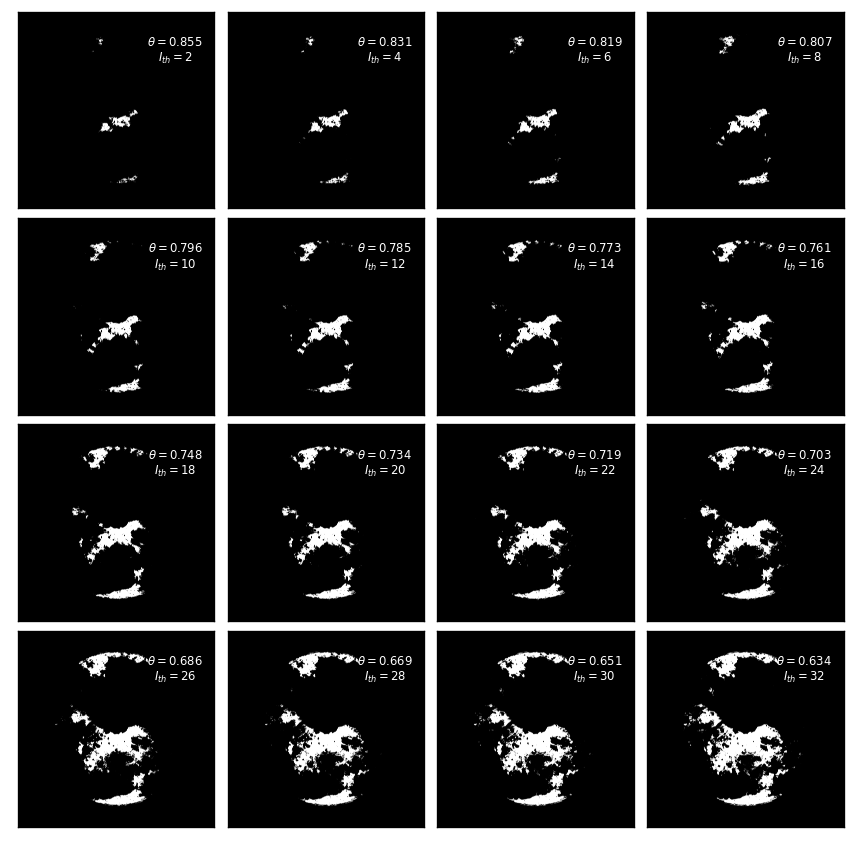

In [6]:
k = 0
fig, axes = plt.subplots(dpi=120, figsize=(9,9), nrows=4, ncols=4, sharex="all", sharey="all")
keys = list(tmp_map.keys())
cmap = matplotlib.cm.gray
cmap.set_bad('k',1.)
for i in range(4):
    for j in range(4):
        ax = axes[i,j]
        ax.imshow(tmp_map[keys[k]], origin="lower", cmap=cmap)
        ax.set_yticks([])
        ax.set_xticks([])
        k += 2
        ax.text(0.8, 0.8, prob_map[keys[k]], ha="center", va="center", transform=ax.transAxes,
                fontdict={"size":7, "color":"w"})
        print(" Limits - ", keys[k])
fig.subplots_adjust(wspace=0.01, hspace=0.05)
plt.show()

In [7]:
import numpy as np
spy = 100000
ret = 160000
#mult = 1.061014
mult = 1.05335
final_ret = 465600
o = 0.
for i in range(25):
    yret = 0
    if i < 12:
        o = o + spy
        o = o*mult
    if i==12: o = o*mult
    if i > 12:
        o = o - ret
        o = o*mult
        yret = ret
    if i==24: yret += final_ret
    print("Year - ", i+1, " Your Invest - ", spy, " Compound-", np.round(o,2), " Ret-", yret)

print("Residue - ", o-yret)
print("Rate - ", np.round(100*(mult-1),4))
print("My in hand - ", ret*11+yret)

Year -  1  Your Invest -  100000  Compound- 105335.0  Ret- 0
Year -  2  Your Invest -  100000  Compound- 216289.62  Ret- 0
Year -  3  Your Invest -  100000  Compound- 333163.67  Ret- 0
Year -  4  Your Invest -  100000  Compound- 456272.96  Ret- 0
Year -  5  Your Invest -  100000  Compound- 585950.12  Ret- 0
Year -  6  Your Invest -  100000  Compound- 722545.56  Ret- 0
Year -  7  Your Invest -  100000  Compound- 866428.36  Ret- 0
Year -  8  Your Invest -  100000  Compound- 1017987.32  Ret- 0
Year -  9  Your Invest -  100000  Compound- 1177631.94  Ret- 0
Year -  10  Your Invest -  100000  Compound- 1345793.6  Ret- 0
Year -  11  Your Invest -  100000  Compound- 1522926.69  Ret- 0
Year -  12  Your Invest -  100000  Compound- 1709509.83  Ret- 0
Year -  13  Your Invest -  100000  Compound- 1800712.18  Ret- 0
Year -  14  Your Invest -  100000  Compound- 1728244.17  Ret- 160000
Year -  15  Your Invest -  100000  Compound- 1651910.0  Ret- 160000
Year -  16  Your Invest -  100000  Compound- 1571